<a href="https://colab.research.google.com/github/shama-llama/crop-mapping/blob/main/src/cmap_msi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Crop Mapping with Deep Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
import os
import io
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

### Parameter Configuration

In [ ]:
# Dataset parameters
hdf5_path = "/content/drive/MyDrive/projects/crop-mapping-with-deep-learning/crop-mapping/dataset/dataset_ca_18.hdf5"
image_size = (65, 65)
image_height, image_width = image_size
sensors = ["RGB", "NDVI45", "GNDVI"]
crop_mapping = {
    "BARLEY": 0,
    "CANOLA": 1,
    "CORN": 2,
    "MIXEDWOOD": 3,
    "OAT": 4,
    "ORCHARD": 5,
    "PASTURE": 6,
    "POTATO": 7,
    "SOYBEAN": 8,
    "SPRING_WHEAT": 9,
}

# Training parameters
batch_size = 16
num_classes = 10
input_shape = (image_height, image_width, 5)
epochs = 50
patience = 5

# Set random seed
random.seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load and Verify Dataset

In [ ]:
# Function to decode an image stored as a variable-length uint8 array
def decode_image(uint8_array, sensor_type):
    if uint8_array.size == 0:
        return None

    image_bytes = uint8_array.tobytes()

    try:
        image = Image.open(io.BytesIO(image_bytes))
        # Convert RGB images to full color.
        if sensor_type == "RGB":
            image = image.convert("RGB")
        # Other sensor types might be encoded as a single channel
        else:
            image = image.convert("L")
        return image
    except Exception as e:
        print(f"Error decoding {sensor_type} image:", e)
        return None

In [ ]:
# Generator for lazy loading records from HDF5 file
def load_records(hdf5_path):
    records = []
    with h5py.File(hdf5_path, "r") as hf:
        num_records = hf["POINT"].shape[0]
        for idx in range(num_records):
            record = {
                "DATE": hf["DATE"][idx],
                "POINT": hf["POINT"][idx],
                "REGION": hf["REGION"][idx],
                "LABEL": hf["LABEL"][idx],
            }
            for sensor in sensors:
                sensor_data = hf[sensor][idx]
                record[sensor] = decode_image(sensor_data, sensor)
            records.append(record)
    return records


# Load records with memory-efficient generator
records = list(load_records(hdf5_path))

# Verification
print(f"Total records loaded: {len(records)}")

Total records loaded: 18325


### Prepare Data Arrays

In [ ]:
def compute_sensor_stats(records, sensors):
    sensor_stats = {}
    for sensor in sensors:
        imgs = []
        for rec in records:
            # Get the sensor image from the record (decoded already)
            img = rec[sensor]
            if img is None:
                continue
            # Convert to numpy array and scale to [0,1]
            arr = np.array(img, dtype=np.float32) / 255.0
            # For non-RGB sensors, ensure a channel dimension
            if sensor != "RGB":
                arr = np.expand_dims(arr, axis=-1)
            imgs.append(arr)
        # Stack all images into a tensor of shape (N, H, W, C)
        all_imgs = np.stack(imgs, axis=0)
        # Compute mean and std over N, H, and W (keeping channel dimension)
        mean = np.mean(all_imgs, axis=(0, 1, 2))
        std = np.std(all_imgs, axis=(0, 1, 2))
        sensor_stats[sensor] = (mean, std)
    return sensor_stats

sensor_stats = compute_sensor_stats(records, sensors)

In [ ]:
# Group records by (POINT, REGION)
grouped = defaultdict(list)
for rec in records:
    key = (rec['POINT'], rec['REGION'])
    grouped[key].append(rec)

# Build sequences: sort by DATE and keep only groups with at least 3 records.
sequences = []
labels = []
for key, recs in grouped.items():
    recs_sorted = sorted(recs, key=lambda r: r['DATE'])
    if len(recs_sorted) >= 3:
        seq_images = []
        for r in recs_sorted:
            # For each sensor, normalize using its channel-wise statistics
            # Assume r[sensor] is a PIL Image from which we obtain a numpy array.
            rgb = np.array(r['RGB'], dtype=np.float32) / 255.0
            # For RGB, sensor_stats['RGB'] returns (mean_rgb, std_rgb) each of shape (3,)
            mean_rgb, std_rgb = sensor_stats['RGB']
            rgb_norm = (rgb - mean_rgb) / std_rgb

            # NDVI45 single-channel images.
            ndvi45 = np.array(r['NDVI45'], dtype=np.float32) / 255.0
            ndvi45 = np.expand_dims(ndvi45, axis=-1)
            mean_ndvi45, std_ndvi45 = sensor_stats['NDVI45']
            ndvi45_norm = (ndvi45 - mean_ndvi45) / std_ndvi45

            # OSAVI single-channel images.
            gndvi = np.array(r['GNDVI'], dtype=np.float32) / 255.0
            gndvi = np.expand_dims(gndvi, axis=-1)
            mean_gndvi, std_gndvi = sensor_stats['GNDVI']
            gndvi_norm = (gndvi - mean_gndvi) / std_gndvi

            # Fuse the normalized sensors (resulting shape: H x W x (3+1+1+1)=H x W x 6)
            fused = np.concatenate([rgb_norm, ndvi45_norm, gndvi_norm], axis=-1)
            seq_images.append(fused)

        sequences.append(np.array(seq_images))
        labels.append(recs_sorted[0]['LABEL'])

print(f"Total sequences with at least 3 time steps: {len(sequences)}")

Total sequences with at least 3 time steps: 4240


### Train/Validation/Test Split

In [ ]:
seq_train, seq_temp, label_train, label_temp = train_test_split(
    sequences, labels, test_size=0.20, stratify=labels, random_state=42
)
seq_val, seq_test, label_val, label_test = train_test_split(
    seq_temp, label_temp, test_size=0.5, stratify=label_temp, random_state=42
)
print("Train sequences:", len(seq_train))
print("Validation sequences:", len(seq_val))
print("Test sequences:", len(seq_test))

Train sequences: 3392
Validation sequences: 424
Test sequences: 424


In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, augment=False):
        self.sequences = sequences
        self.labels = labels
        self.augment = augment
        # Base transform: converts numpy array (H,W,C) to tensor (C,H,W)
        self.base_transform = transforms.Compose([
            transforms.Lambda(lambda x: torch.from_numpy(x).permute(2, 0, 1).float()),
        ])
        # Spatial augmentations only
        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=(-25, 25)),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]   # seq is an array of fused images (each a numpy array)
        label = self.labels[idx]
        processed_seq = []
        for img in seq:
            img_tensor = self.base_transform(img)
            if self.augment:
                img_tensor = self.augment_transform(img_tensor)
            processed_seq.append(img_tensor)
        seq_length = len(processed_seq)
        # Do not pad here; return the list and its length
        return processed_seq, label, seq_length

def collate_fn(batch):
    # Each element in batch is a tuple: (list_of_tensors, label, seq_length)
    sequences, labels, lengths = zip(*batch)
    # Convert list of tensors for each sample into a tensor of shape (seq_len, C, H, W)
    sequences = [torch.stack(seq) for seq in sequences]
    # Pad sequences to have same length (batch_first=True gives shape: (batch, max_seq_len, C, H, W))
    padded_seqs = pad_sequence(sequences, batch_first=True)
    labels = torch.tensor(labels)
    # No sorting and packing required for the new model
    return padded_seqs, labels, lengths

train_dataset = SequenceDataset(seq_train, label_train, augment=True)
val_dataset = SequenceDataset(seq_val, label_val, augment=False)
test_dataset = SequenceDataset(seq_test, label_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True, collate_fn=collate_fn)

### Model Definition

In [ ]:
# Updated ConvLSTMCell
class ConvLSTMCell(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """
        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding     = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.bias        = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

        print('ConvLSTM cell constructed with hidden dim:', hidden_dim)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
       # FIX: Ensure hidden states are on the same device as input_tensor
        h_cur = h_cur.to(input_tensor.device)
        c_cur = c_cur.to(input_tensor.device)

        # Concatenate along channel axis
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size):
        # Ensure hidden states are created on the same device as the model's parameters.
        device = next(self.parameters()).device
        h = torch.zeros(batch_size, self.hidden_dim, self.height, self.width, device=device)
        c = torch.zeros(batch_size, self.hidden_dim, self.height, self.width, device=device)
        return h, c


# Updated ConvLSTM module
class ConvLSTM(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=True):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Ensure kernel_size and hidden_dim are lists of length num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))
        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None, cell_state=None):
        """
        Parameters
        ----------
        input_tensor: 5-D Tensor of shape (b, t, c, h, w) if batch_first=True
        hidden_state: initial hidden states (optional)
        cell_state: initial cell states (optional)

        Returns
        -------
        layer_output_list, last_state_list
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, seq_len, _, h, w = input_tensor.size()

        # Initialize hidden states if not provided
        if hidden_state is None or cell_state is None:
            hidden_state = []
            cell_state = []
            for i in range(self.num_layers):
                h_i, c_i = self.cell_list[i].init_hidden(b)
                hidden_state.append(h_i)
                cell_state.append(c_i)

        layer_output_list = []
        last_state_list = []
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h = hidden_state[layer_idx]
            c = cell_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)
            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


# Updated classifier model using the new ConvLSTM
class ConvLSTMClassifier(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers, num_classes, bias=True):
        super(ConvLSTMClassifier, self).__init__()
        self.convlstm = ConvLSTM(input_size=input_size,
                                 input_dim=input_dim,
                                 hidden_dim=hidden_dim,
                                 kernel_size=kernel_size,
                                 num_layers=num_layers,
                                 batch_first=True,
                                 bias=bias,
                                 return_all_layers=False)
        # Adaptive pooling to reduce spatial dimensions and a fully connected layer for classification
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_dim[-1], num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, channels, height, width)
        _, last_state_list = self.convlstm(x)
        h, _ = last_state_list[0]  # Last hidden state from final layer
        pooled = self.pool(h)      # (batch, hidden_dim, 1, 1)
        pooled = pooled.view(pooled.size(0), -1)
        out = self.fc(pooled)
        return out

In [ ]:
# Calculate the frequency of each class in label_train
classes = np.unique(label_train)
class_weights = compute_class_weight('balanced', classes=classes, y=label_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize Model, Loss, and Optimizer
model = ConvLSTMClassifier(input_size=(65, 65),
                           input_dim=5,
                           hidden_dim=[32, 64],
                           kernel_size=[(3, 3), (3, 3)],
                           num_layers=2,
                           num_classes=10,
                           bias=True).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

ConvLSTM cell constructed with hidden dim: 32
ConvLSTM cell constructed with hidden dim: 64


### Model Training

In [ ]:
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_correct = 0
    for seqs, labels, lengths in train_loader:
        seqs = seqs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_correct / len(train_loader.dataset)
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    lr_scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for seqs, labels, lengths in val_loader:
            seqs = seqs.to(device)
            labels = labels.to(device)

            outputs = model(seqs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / len(val_loader.dataset)
    history['val_loss'].append(val_epoch_loss)
    history['val_accuracy'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}\n")

    # Early stopping check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1/50
Train Loss: 1.6523, Acc: 0.5012
Val Loss: 1.2730, Acc: 0.6061

Epoch 2/50
Train Loss: 1.1953, Acc: 0.6704
Val Loss: 1.0856, Acc: 0.7193

Epoch 3/50
Train Loss: 1.0512, Acc: 0.7087
Val Loss: 0.9507, Acc: 0.7358

Epoch 4/50
Train Loss: 0.9718, Acc: 0.7270
Val Loss: 0.9655, Acc: 0.7146

Epoch 5/50
Train Loss: 0.8983, Acc: 0.7456
Val Loss: 0.8396, Acc: 0.7382

Epoch 6/50
Train Loss: 0.8368, Acc: 0.7656
Val Loss: 0.8282, Acc: 0.7335

Epoch 7/50
Train Loss: 0.7795, Acc: 0.7786
Val Loss: 0.8207, Acc: 0.7429

Epoch 8/50
Train Loss: 0.7697, Acc: 0.7795
Val Loss: 0.8065, Acc: 0.7712

Epoch 9/50
Train Loss: 0.7302, Acc: 0.7871
Val Loss: 0.8244, Acc: 0.7406

Epoch 10/50
Train Loss: 0.6873, Acc: 0.8010
Val Loss: 0.7665, Acc: 0.7736

Epoch 11/50
Train Loss: 0.6690, Acc: 0.8104
Val Loss: 0.7734, Acc: 0.7807

Epoch 12/50
Train Loss: 0.6325, Acc: 0.8184
Val Loss: 0.7820, Acc: 0.7571

Epoch 13/50
Train Loss: 0.6210, Acc: 0.8205
Val Loss: 0.7752, Acc: 0.7712

Epoch 14/50
Train Loss: 0.5907, Ac

### Model Evaluation

Test Loss: 0.6111, Test Accuracy: 0.8467


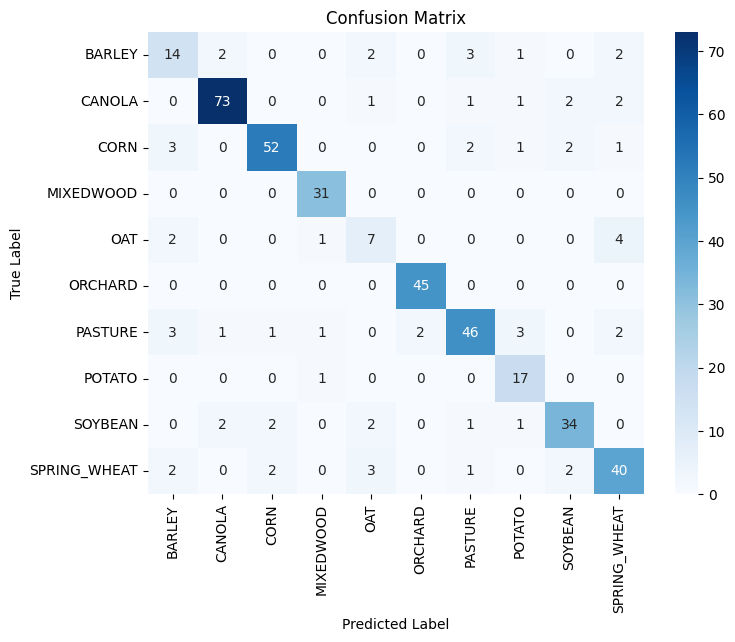

Classification Report:
              precision    recall  f1-score   support

      BARLEY       0.58      0.58      0.58        24
      CANOLA       0.94      0.91      0.92        80
        CORN       0.91      0.85      0.88        61
   MIXEDWOOD       0.91      1.00      0.95        31
         OAT       0.47      0.50      0.48        14
     ORCHARD       0.96      1.00      0.98        45
     PASTURE       0.85      0.78      0.81        59
      POTATO       0.71      0.94      0.81        18
     SOYBEAN       0.85      0.81      0.83        42
SPRING_WHEAT       0.78      0.80      0.79        50

    accuracy                           0.85       424
   macro avg       0.80      0.82      0.80       424
weighted avg       0.85      0.85      0.85       424



In [ ]:

model.eval()
test_loss = 0.0
correct = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for seqs, labels, lengths in test_loader:
        seqs = seqs.to(device)
        labels = labels.to(device)

        outputs = model(seqs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Confusion Matrix and Classification Report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(crop_mapping.keys()),
            yticklabels=list(crop_mapping.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(all_labels, all_preds, target_names=list(crop_mapping.keys()))
print("Classification Report:")
print(report)

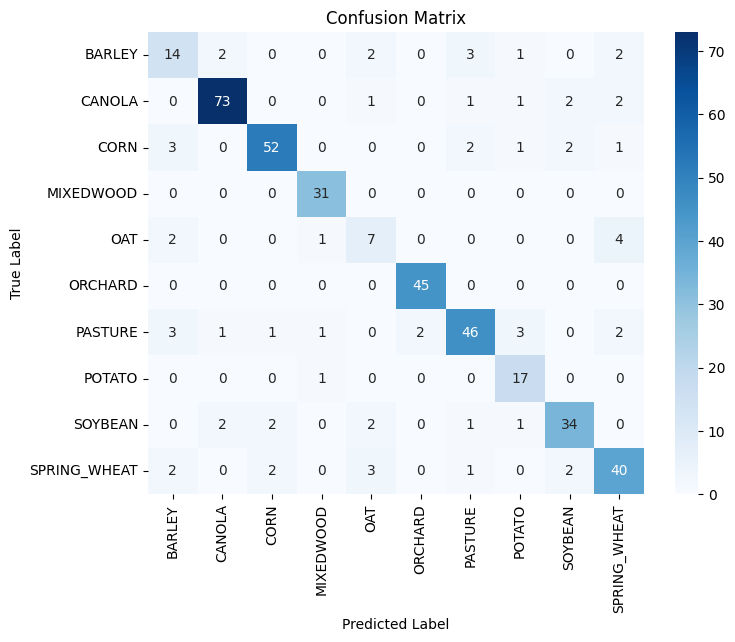

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(crop_mapping.keys()),
            yticklabels=list(crop_mapping.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Compute and print classwise metrics
report = classification_report(all_labels, all_preds, target_names=list(crop_mapping.keys()))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      BARLEY       0.58      0.58      0.58        24
      CANOLA       0.94      0.91      0.92        80
        CORN       0.91      0.85      0.88        61
   MIXEDWOOD       0.91      1.00      0.95        31
         OAT       0.47      0.50      0.48        14
     ORCHARD       0.96      1.00      0.98        45
     PASTURE       0.85      0.78      0.81        59
      POTATO       0.71      0.94      0.81        18
     SOYBEAN       0.85      0.81      0.83        42
SPRING_WHEAT       0.78      0.80      0.79        50

    accuracy                           0.85       424
   macro avg       0.80      0.82      0.80       424
weighted avg       0.85      0.85      0.85       424



### Plot Training Curves

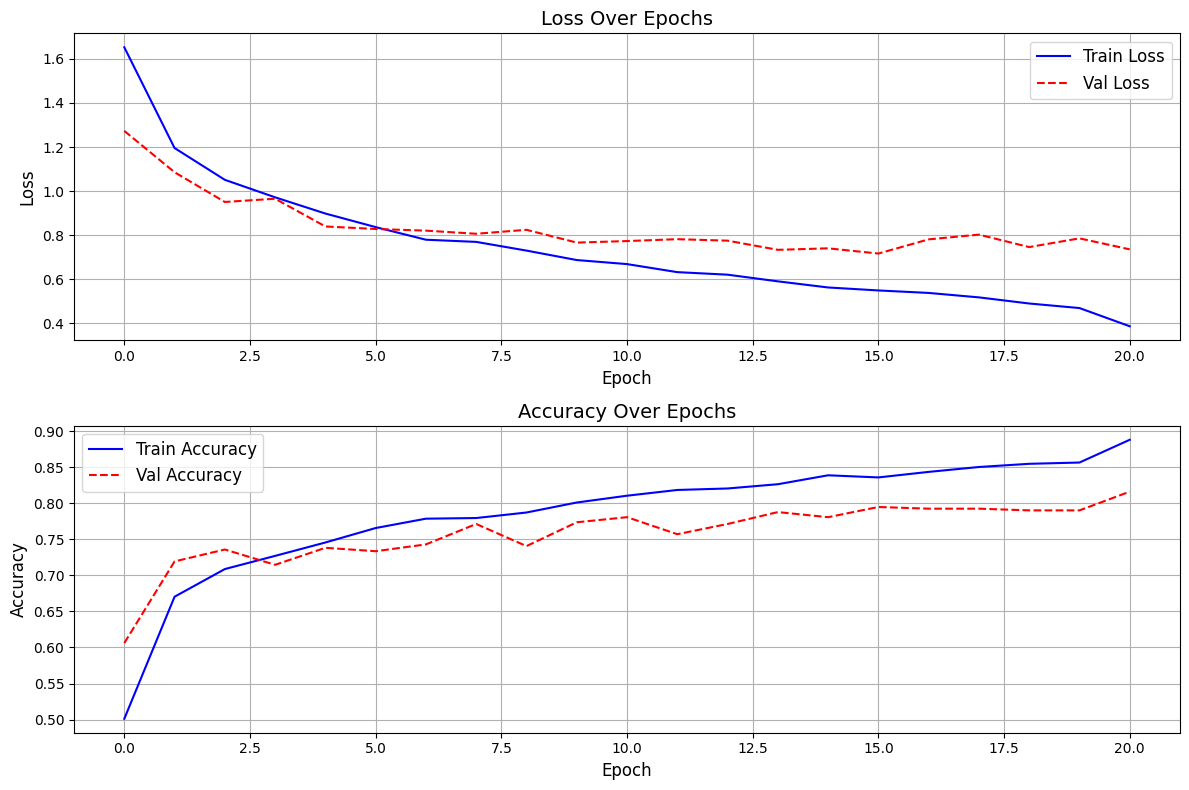

In [ ]:
plt.figure(figsize=(12, 8))

# Loss Plot
plt.subplot(2, 1, 1)
plt.plot(history['loss'], label='Train Loss', color='blue', linestyle='-')
plt.plot(history['val_loss'], label='Val Loss', color='red', linestyle='--')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Accuracy Plot
plt.subplot(2, 1, 2)
plt.plot(history['accuracy'], label='Train Accuracy', color='blue', linestyle='-')
plt.plot(history['val_accuracy'], label='Val Accuracy', color='red', linestyle='--')
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()